In [1]:
import sys
# load standard python modules
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# load torch modules
import torch
import torch.nn as nn
import torch.nn.functional as F

# load custom modules required for jetCLR training
from modules.jet_augs import translate_jets, rotate_jets, rescale_pts, distort_jets, collinear_fill_jets, crop_jets
from modules.transformer import Transformer
from modules.losses import contrastive_loss, align_loss, uniform_loss, contrastive_loss_num_den
from modules.perf_eval import get_perf_stats, linear_classifier_test, plot_losses


torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
torch.cuda.empty_cache()


from numba import cuda 
device = cuda.get_current_device()
device.reset()


In [2]:
# More parameters / computing setup

# set the number of threads that pytorch will use
torch.set_num_threads(2)

exp_id = "2909"

# set gpu device
device = torch.device( "cuda" if torch.cuda.is_available() else "cpu")
print( "device: " + str( device ), flush=True)

# set up results directory
base_dir = "/global/home/users/rrmastandrea/MJetCLR/"  # change this to your working directory
expt_dir = base_dir + "projects/rep_learning/experiments/" + exp_id + "/"

#check if experiment alreadyexists
if os.path.isdir(expt_dir):
    print("ERROR: experiment already exists, don't want to overwrite it by mistake")
    pass
else:
    os.makedirs(expt_dir)

print("experiment: "+str(exp_id) , flush=True)


device: cuda
ERROR: experiment already exists, don't want to overwrite it by mistake
experiment: 2909


# Load in the processed data

In [3]:
path_to_save_dir = "/global/home/users/rrmastandrea/training_data/"


save_id_dir = "n_sig_6556_n_bkg_63543_n_nonzero_20_n_pad_30/"

path_to_data = path_to_save_dir+save_id_dir
print(path_to_data)


clr_train = np.load(path_to_data+"clr_train.npy")
clr_val = np.load(path_to_data+"clr_val.npy")
data_train = np.load(path_to_data+"data_train.npy")
labels_train = np.load(path_to_data+"labels_train.npy")
data_val = np.load(path_to_data+"data_val.npy")
labels_val = np.load(path_to_data+"labels_val.npy")
data_test_f = np.load(path_to_data+"data_test_f.npy")
labels_test_f = np.load(path_to_data+"labels_test_f.npy")

# print data dimensions
print( "CLR training data shape: " + str( clr_train.shape ), flush=True)
print( "CLR val data shape: " + str( clr_val.shape ), flush=True)
print( "BC training data shape: " + str( data_train.shape ), flush=True)
print( "BC training labels shape: " + str( labels_train.shape ), flush=True)
print( "BC val data shape: " + str( data_val.shape ), flush=True)
print( "BC val labels shape: " + str( labels_val.shape ), flush=True)
print( "BC test data shape: " + str( data_test_f.shape ), flush=True)
print( "BC test labels shape: " + str( labels_test_f.shape ), flush=True)


# Plot num constituents

def get_num_constits(dataset):
    consits_list = []
    for collision in dataset:
        pts = collision[0,:]

        pads = np.where(pts==0)
        consits_list.append(dataset.shape[2]-len(pads[0]))
        
    return consits_list
        

/global/home/users/rrmastandrea/training_data/n_sig_6556_n_bkg_63543_n_nonzero_20_n_pad_30/
CLR training data shape: (11644, 3, 50)
CLR val data shape: (2912, 3, 50)
BC training data shape: (10189, 3, 50)
BC training labels shape: (10189,)
BC val data shape: (2183, 3, 50)
BC val labels shape: (2183,)
BC test data shape: (2183, 3, 50)
BC test labels shape: (2183,)


# Define the Transformer Net

In [9]:
"""
Define the transformer net
"""

# transformer hyperparams
# input dim to the transformer -> (pt,eta,phi)
input_dim = 3
model_dim = 1000
output_dim = 1000
n_heads = 2
dim_feedforward = 1000
n_layers = 2
n_head_layers = 2
opt = "adam"

mask= False
cmask = True

learning_rate_trans = 0.0001
batch_size = 256
temperature = 0.5

# augmentations
rot = True # rotations
trs = True # translations
trsw = 1.0
dis = True # distortion
ptcm = 0.1
ptst = 0.1
col = True # collinear


net = Transformer( input_dim, model_dim, output_dim, n_heads, dim_feedforward, 
                  n_layers, learning_rate_trans, n_head_layers, dropout=0.1, opt=opt )

## send network to device
net.to( device )

# define lr scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau( net.optimizer, factor=0.2 )


In [10]:
run_transformer = True

grading = 20
n_constits_max = grading

if run_transformer:
    
    # THE TRAINING LOOP

    # initialise lists for storing training stats, validation loss
    losses_clr_num_jets = {i:[] for i in range(grading,n_constits_max+grading,grading)}
    losses_clr_numer_num_jets = {i:[] for i in range(grading,n_constits_max+grading,grading)}
    losses_clr_denom_num_jets = {i:[] for i in range(grading,n_constits_max+grading,grading)}
    loss_validation_num_jets = {i:[[],[]] for i in range(grading,n_constits_max+grading,grading)} #epoch, loss
    lct_auc_num_jets = {i:[[],[],[],[]] for i in range(grading,n_constits_max+grading,grading)} #epoch, auc (pt, eta, phi)


    n_epochs = 50
    loss_check_epoch = 10
    verbal_epoch = 5

    mean_consts_post_split = []



    for constit_num in range(grading,n_constits_max+grading,grading):

        t0 = time.time()

        print( "starting training loop, running for " + str( n_epochs ) + " epochs" + " with " + str(constit_num) + " constituents" 
              , flush=True)
        print("Training data shape:",clr_train.shape)
        print("Validation data shape:",clr_val.shape)
        print( "---", flush=True )

        # re-batch the data on each epoch
        for epoch in range( n_epochs + 1 ):

            # get batch_size number of indices
            indices_list = torch.split( torch.randperm( clr_train.shape[0] ), batch_size )

            # initialise lists to store batch stats
            losses_clr_e = []
            losses_clr_numer_e = []
            losses_clr_denom_e = []

            # the inner loop goes through the dataset batch by batch
            # augmentations of the jets are done on the fly
            for i, indices in enumerate( indices_list ): # random jets from the dataset
                net.optimizer.zero_grad()
                """
                TRANSFORMATIONS AND DATA PREPARATION
                """
                x_i = clr_train[indices,:,:]
                x_j = x_i.copy()

                if rot:
                    x_j = rotate_jets( x_j )
                if trs:
                    x_j = translate_jets( x_j, width=trsw )
                if dis:
                    x_j = distort_jets( x_j, strength=ptst, pT_clip_min=ptcm )
                if col:
                    x_j = collinear_fill_jets( x_j )
                    x_j = collinear_fill_jets( x_j )
                mean_consts_post_split.append(np.mean(get_num_constits(x_j)))

                x_i = torch.Tensor( x_i ).transpose(1,2).to( device ) # shape (batchsize, 2, 3)
                x_j = torch.Tensor( x_j ).transpose(1,2).to( device )
                z_i = net( x_i, use_mask=mask, use_continuous_mask=cmask ) # shape (batchsize, output_dim)
                z_j = net( x_j, use_mask=mask, use_continuous_mask=cmask )

                """
                LOSS CALCULATIONS
                """            
                # compute the loss based on predictions of the net and the correct answers
                loss = contrastive_loss( z_i, z_j, device, temperature, 1 ).to( device )
                [loss_numer, loss_denom] = [l.detach().cpu().numpy()  for l in contrastive_loss_num_den( z_i, z_j, device, temperature )]
                loss.backward()
                net.optimizer.step()
                net.optimizer.zero_grad()
                losses_clr_e.append( loss.detach().cpu().numpy() )
                losses_clr_numer_e.append(loss_numer)
                losses_clr_denom_e.append(loss_denom)

            """
            AVERAGING OF LOSSES
            """ 
            loss_clr_e = np.mean( np.array( losses_clr_e ) )
            ## scheduler
            scheduler.step( loss_clr_e )

            # storage
            losses_clr_num_jets[constit_num].append( loss_clr_e )
            losses_clr_numer_num_jets[constit_num].append( np.mean( np.array( losses_clr_numer_e ) ) )
            losses_clr_denom_num_jets[constit_num].append( np.mean( np.array( losses_clr_denom_e ) ) )

            """
            EVERY SO OFTEN, GIVEN AN UPDATE
            """

            if epoch % verbal_epoch == 0:


                print( "epoch: " + str( epoch ) + ", loss: " + str( round(losses_clr_num_jets[constit_num][-1], 5) ), flush=True )
                #print( "lr: " + str( scheduler._last_lr ), flush=True  )
                # summarize alignment and uniformity stats
                print( "numerator: " + str( losses_clr_numer_num_jets[constit_num][-1] ) + ", denominator: " + str( losses_clr_denom_num_jets[constit_num][-1] ), flush=True)
                print("time taken up to now: " + str(time.time()-t0))
                print()

            if epoch % loss_check_epoch == 0:

                """
                Get the validation loss
                """
                print("Getting the validation CLR loss...")
                # store the epoch
                loss_validation_num_jets[constit_num][0].append(epoch)

                with torch.no_grad():
                    net.eval()

                    # get batch_size number of indices
                    indices_list_val = torch.split( torch.randperm( clr_val.shape[0] ), batch_size )
                    local_val_losses = []

                    for j, indices_val in enumerate( indices_list_val ):
                        a_i = clr_val[indices_val,:,:]
                        a_j = a_i.copy()
                        if rot:
                            a_j = rotate_jets( a_j )
                        if trs:
                            a_j = translate_jets( a_j, width=trsw )
                        if dis:
                            a_j = distort_jets( a_j, strength=ptst, pT_clip_min=ptcm )
                        if col:
                            a_j = collinear_fill_jets( a_j )
                            a_j = collinear_fill_jets( a_j )


                        a_i = torch.Tensor( a_i ).transpose(1,2).to( device ) # shape (batchsize, 2, 3)
                        a_j = torch.Tensor( a_j ).transpose(1,2).to( device )
                        w_i = net( a_i, use_mask=mask, use_continuous_mask=cmask ) # shape (batchsize, output_dim)
                        w_j = net( a_j, use_mask=mask, use_continuous_mask=cmask )

                        loss_val = contrastive_loss( w_i, w_j, device, temperature, 1 ).to( device )
                        local_val_losses.append(loss_val.detach().cpu().numpy())

                    loss_val_e = np.mean( np.array( local_val_losses ) )
                    loss_validation_num_jets[constit_num][1].append(loss_val_e)

                """
                Run a LCT for signal vs background (supervised)
                """

                net.eval()
                lct_train_reps = F.normalize( net.forward_batchwise( torch.Tensor( data_test_f ).transpose(1,2), data_test_f.shape[0], use_mask=mask, use_continuous_mask=cmask ).detach().cpu() ).numpy()
                lct_test_reps = F.normalize( net.forward_batchwise( torch.Tensor( data_val ).transpose(1,2), data_val.shape[0], use_mask=mask, use_continuous_mask=cmask ).detach().cpu() ).numpy()


                print("Doing a short LCT...")

                lct_auc_num_jets[constit_num][0].append(epoch)
                # Need to transform the data into the representation space first
                with torch.no_grad():
                    for trait in range(lct_train_reps.shape[1]): # going through the layers of the transformer
                        # run the LCT
                        reg = LinearRegression().fit(lct_train_reps[:,trait,:], labels_test_f)
                        # make the prediction
                        predictions = reg.predict(lct_test_reps[:,trait,:])
                        auc = roc_auc_score(labels_val, predictions)
                        lct_auc_num_jets[constit_num][1+trait].append(auc)
            

        t1 = time.time()

        print( "JETCLR TRAINING DONE, time taken: " + str( np.round( t1-t0, 2 ) ), flush=True)


        # save out results
        print( "saving out data/results", flush=True)
        np.save( expt_dir+"clr_losses_train_"+str(constit_num)+".npy", losses_clr_num_jets[constit_num] )
        np.save( expt_dir+"clr_numer_loss_train_"+str(constit_num)+".npy", losses_clr_numer_num_jets[constit_num] )
        np.save( expt_dir+"clr_denom_loss_train_"+str(constit_num)+".npy", losses_clr_denom_num_jets[constit_num] )
        np.save( expt_dir+"clr_losses_val_"+str(constit_num)+".npy", loss_validation_num_jets[constit_num] )
        np.save( expt_dir+"lct_auc_"+str(constit_num)+".npy", lct_auc_num_jets[constit_num] )

        # save out final trained model
        print( "saving out final jetCLR model", flush=True )
        torch.save(net.state_dict(), expt_dir+"final_model_"+str(constit_num)+".pt")
        print()

        print("Avg # constits:", np.mean(mean_consts_post_split))


starting training loop, running for 50 epochs with 20 constituents
Training data shape: (11644, 3, 50)
Validation data shape: (2912, 3, 50)
---
epoch: 0, loss: 5.82873
numerator: -1.4649076, denominator: -7.293637
time taken up to now: 13.900445461273193

Getting the validation CLR loss...
Doing a short LCT...
epoch: 5, loss: 5.36101
numerator: -1.4004444, denominator: -6.761458
time taken up to now: 97.47154188156128

epoch: 10, loss: 5.16565
numerator: -1.5062187, denominator: -6.671869
time taken up to now: 166.48743319511414

Getting the validation CLR loss...
Doing a short LCT...
epoch: 15, loss: 5.10932
numerator: -1.5083631, denominator: -6.617682
time taken up to now: 243.79971027374268

epoch: 20, loss: 5.07333
numerator: -1.5130479, denominator: -6.586375
time taken up to now: 312.89853167533875

Getting the validation CLR loss...
Doing a short LCT...
epoch: 25, loss: 5.0507
numerator: -1.5208685, denominator: -6.5715737
time taken up to now: 409.34629106521606

epoch: 30, lo

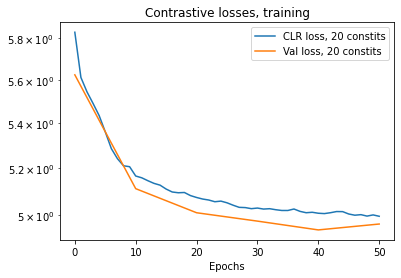

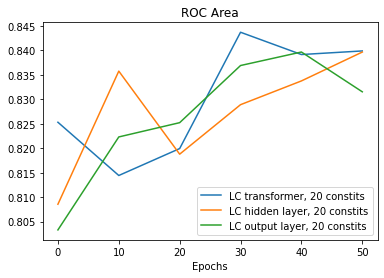

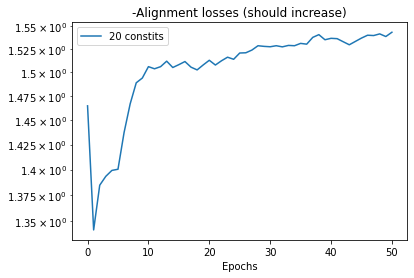

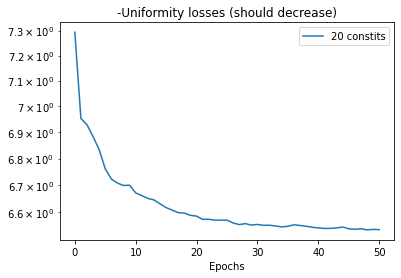

In [11]:
"""
Plot the training contrastive losses
"""
plot_clr_losses = []

plot_clr_losses.append((range(len(losses_clr_num_jets[constit_num])),
                       losses_clr_num_jets[constit_num], "CLR loss, "+str(constit_num) + " constits"))
plot_clr_losses.append((loss_validation_num_jets[constit_num][0],
                       loss_validation_num_jets[constit_num][1],"Val loss, "+str(constit_num) + " constits"))
plot_losses(plot_clr_losses, "Contrastive losses, training", True)  
    
"""
Plot the LC + NN AUC
"""

plot_LCT_stats = []
plot_LCT_stats.append((lct_auc_num_jets[constit_num][0], lct_auc_num_jets[constit_num][1],
                         "LC transformer, "+str(constit_num) + " constits"))
plot_LCT_stats.append((lct_auc_num_jets[constit_num][0], lct_auc_num_jets[constit_num][2],
                        "LC hidden layer, "+str(constit_num) + " constits"))
plot_LCT_stats.append((lct_auc_num_jets[constit_num][0], lct_auc_num_jets[constit_num][3],
                        "LC output layer, "+str(constit_num) + " constits"))

plot_losses(plot_LCT_stats, "ROC Area", False)  


    
"""
Plot the training contrastive losses num + denom
"""

plot_num_val_losses = []

plot_num_val_losses.append((range(len(losses_clr_numer_num_jets[constit_num])),
                       -1*np.array(losses_clr_numer_num_jets[constit_num]), str(constit_num) + " constits"))
plot_losses(plot_num_val_losses, "-Alignment losses (should increase)", True)  

plot_den_val_losses = []

plot_den_val_losses.append((range(len(losses_clr_denom_num_jets[constit_num])),
                       -1*np.array(losses_clr_denom_num_jets[constit_num]),  str(constit_num) + " constits"))
plot_losses(plot_den_val_losses, "-Uniformity losses (should decrease)", True)  


    

# Run final LCT on the transformer representations

In [12]:
constit_num = grading

# Loading in the final transformer

loaded_net = Transformer( input_dim, model_dim, output_dim, n_heads, dim_feedforward, 
                  n_layers, learning_rate_trans, n_head_layers, dropout=0.1, opt=opt )

loaded_net.load_state_dict(torch.load(expt_dir+"final_model_"+str(constit_num)+".pt"))
loaded_net.eval()


Transformer(
  (embedding): Linear(in_features=3, out_features=1000, bias=True)
  (decoder): Linear(in_features=1000, out_features=1, bias=True)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=1000, out_features=1000, bias=True)
        )
        (linear1): Linear(in_features=1000, out_features=1000, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=1000, out_features=1000, bias=True)
        (norm1): LayerNorm((1000,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((1000,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=1000, out_f

Loading data into net...
Data loaded!
Doing a LCT...


/global/home/users/rrmastandrea/computingEnv/lib64/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in true_divide
/global/home/users/rrmastandrea/computingEnv/lib64/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in true_divide
/global/home/users/rrmastandrea/computingEnv/lib64/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in true_divide


LCT data saved


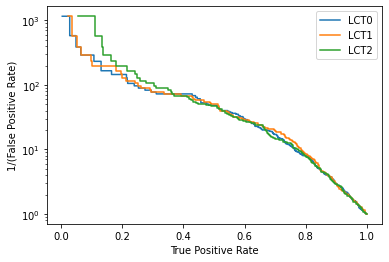

In [13]:
# Running the final transformer on the binary classification data

print("Loading data into net...")
lct_train_reps = F.normalize( loaded_net.forward_batchwise( torch.Tensor( data_train ).transpose(1,2), data_train.shape[0], use_mask=mask, use_continuous_mask=cmask ).detach().cpu() ).numpy()
lct_test_reps = F.normalize( loaded_net.forward_batchwise( torch.Tensor( data_test_f ).transpose(1,2), data_test_f.shape[0], use_mask=mask, use_continuous_mask=cmask ).detach().cpu() ).numpy()
print("Data loaded!")

lct_fpt_tpr = {0:{"fpr":[],"tpr":[]},
              1:{"fpr":[],"tpr":[]},
              2:{"fpr":[],"tpr":[]}}


plt.figure()

print("Doing a LCT...")
# Need to transform the data into the representation space first
with torch.no_grad():
    for trait in range(lct_train_reps.shape[1]): # going through the layers of the transformer
        # run the LCT
        reg = LinearRegression().fit(lct_train_reps[:,trait,:], labels_train)
        # make the prediction
        predictions = reg.predict(lct_test_reps[:,trait,:])
        fpr, tpr, _ = roc_curve(labels_test_f, predictions)
        
        plt.plot(tpr, 1.0/fpr, label = "LCT"+str(trait))
        
        np.save( expt_dir+"CLR_LCT"+str(trait)+"_fpr_"+str(constit_num)+".npy", fpr )
        np.save( expt_dir+"CLR_LCT"+str(trait)+"_tpr_"+str(constit_num)+".npy", tpr )
        
print("LCT data saved")





plt.yscale("log")
plt.xlabel("True Positive Rate")
plt.ylabel("1/(False Positive Rate)")
plt.legend()
plt.show()


